In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from numpyro.contrib.module import random_flax_module
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro_ext import optim as optimx

from paton_nn.model import Paton

jax.config.update("jax_enable_x64", True)
%matplotlib inline

In [54]:
L = 2  # number of labels
T = 8  # number of latents
F = 32  # number of flux values
N = 2048  # number of stars

rng = np.random.default_rng(seed=8675209)

# alpha = rng.normal(0., label_scales, size=(M, K))
alpha = np.zeros((L, T))
alpha[0, 0] = 1.0
alpha[1, 1] = 1.0

beta = rng.normal(scale=0.1, size=(F, T))
beta[:, 0] = beta[:, 0] + 4 * np.exp(
    -0.5 * (np.arange(beta.shape[0]) - beta.shape[0] / 2) ** 2 / 2**2
)
beta[:, 1] = beta[:, 1] + 2 * np.exp(
    -0.5 * (np.arange(beta.shape[0]) - beta.shape[0] / 4) ** 2 / 1**2
)


def make_data(N, rng):
    # label_scales = 10 ** rng.uniform(-2, 2, size=(M, 1))
    label_scales = jnp.ones((L, 1))

    zeta = rng.normal(size=(N, T))

    labels = (alpha @ zeta.T).T
    fluxs = (beta @ zeta.T).T

    label_err = rng.uniform(0.01, 0.1, size=labels.shape) * label_scales.T
    flux_err = rng.uniform(0.01, 0.1, size=fluxs.shape)

    obs = {
        "label": rng.normal(labels, label_err),
        "label_err": label_err,
        "flux": rng.normal(fluxs, flux_err),
        "flux_err": flux_err,
    }
    truth = {
        "label": labels,
        "flux": fluxs,
        "alpha": alpha,
        "beta": beta,
        "zeta": zeta,
    }

    return obs, truth


data, data_true = make_data(N, rng=rng)
test_data, test_data_true = make_data(N, rng=rng)

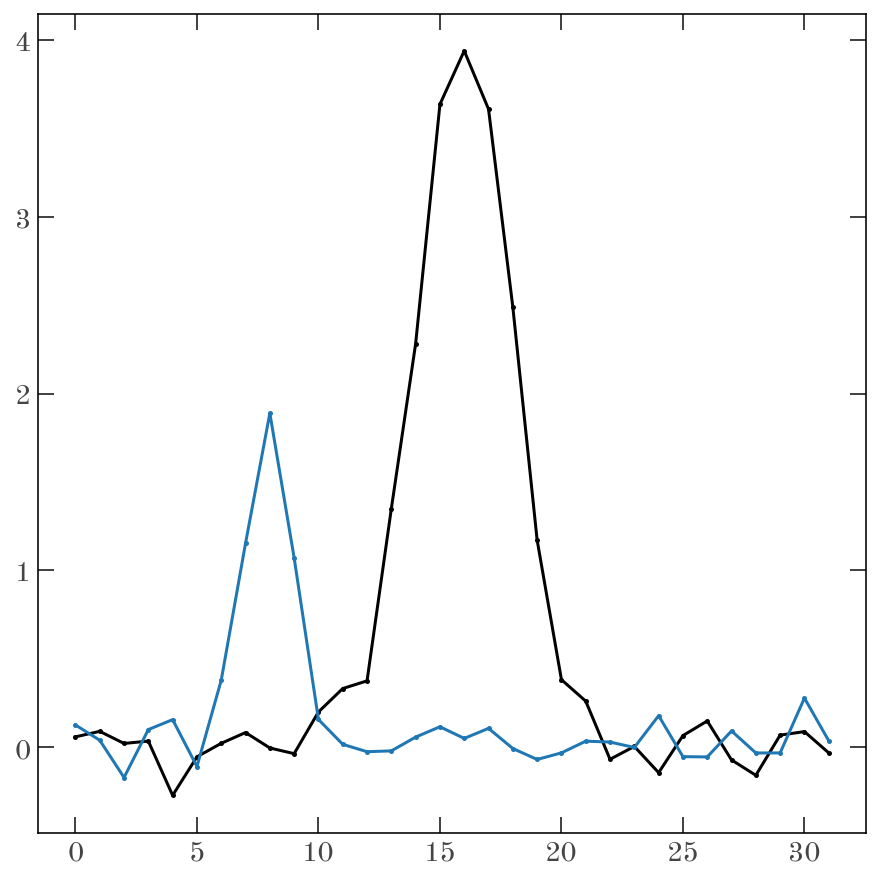

In [55]:
plt.plot(beta[:, 0])
plt.plot(beta[:, 1])

In [56]:
paton_model = Paton(latent_size=T)
paton_model.register_output(
    "labels",
    size=8,
    transform=lambda z, A, b: A @ z + b,
    transform_params={
        "A": dist.Normal(0, 1).expand((L, paton_model.latent_size)),
        "b": dist.Normal(0, 1).expand((L,)),
    },
)
paton_model.register_output(
    "flux",
    size=F,
    transform=lambda z, A, b: A @ z + b,
    transform_params={
        "A": dist.Normal(0, 1).expand((F, paton_model.latent_size)),
        "b": dist.Normal(0, 1).expand((F,)),
    },
)

Test evaluating the model:

In [57]:
z = jax.random.normal(jax.random.PRNGKey(0), shape=(N, paton_model.latent_size))
params = {
    "labels": {
        "A": jax.random.normal(
            jax.random.PRNGKey(1), shape=(L, paton_model.latent_size)
        ),
        "b": jnp.zeros((L,)),
    },
    "flux": {
        "A": jax.random.normal(
            jax.random.PRNGKey(2), shape=(F, paton_model.latent_size)
        ),
        "b": jnp.zeros((F,)),
    },
}
outputs = paton_model.predict_outputs(z, params)
outputs["labels"].shape, outputs["flux"].shape

((2048, 2), (2048, 32))

In [58]:
# _data = {"labels": data["label"], "flux": data["flux"]}
# _err = {"labels": data["label_err"], "flux": data["flux_err"]}
# paton_model.default_numpyro_model(_data, _err)

# opt = optimx.optimize(
#     paton_model.default_numpyro_model,
#     optimizer=numpyro.optim.Adam(1e-3),
#     num_steps=1_000,
# )
# res = opt(jax.random.PRNGKey(101), _data, _err)

In [59]:
rng_key = jax.random.PRNGKey(112358)

svi_key, sample_key = jax.random.split(rng_key, 2)

_data = {"labels": data["label"], "flux": data["flux"]}
_err = {"labels": data["label_err"], "flux": data["flux_err"]}

optimizer = numpyro.optim.Adam(1e-3)
guide = AutoDelta(paton_model.default_numpyro_model)
svi = SVI(paton_model.default_numpyro_model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(svi_key, 100_000, _data, _err)
unpacked_MAP_params = guide.sample_posterior(sample_key, svi_results.params)
MAP_params = paton_model.unpack_numpyro_params(unpacked_MAP_params)

100%|██████████| 100000/100000 [00:29<00:00, 3354.22it/s, init loss: 77125643.9854, avg. loss [95001-100000]: -105854.6115]


In [60]:
MAP_train_values = paton_model.predict_outputs(MAP_params["latent_z"], MAP_params)

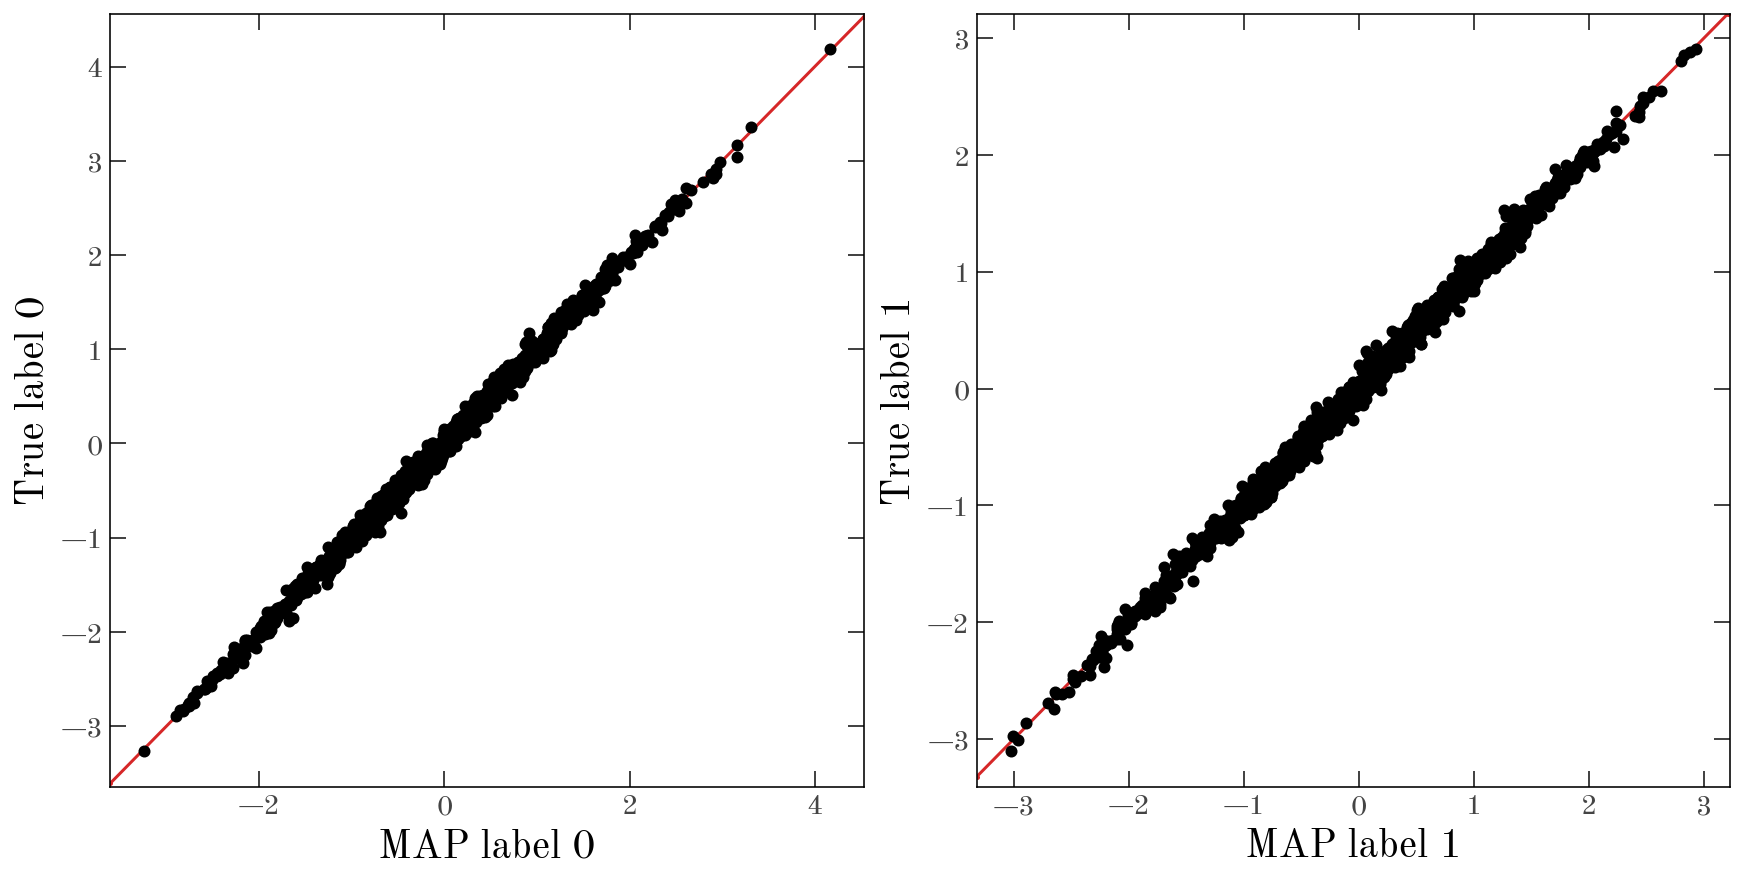

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in range(MAP_train_values["labels"].shape[1]):
    axes[i].scatter(MAP_train_values["labels"][:, i], data["label"][:, i])
    axes[i].set_xlabel(f"MAP label {i}")
    axes[i].set_ylabel(f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:red", zorder=-100)

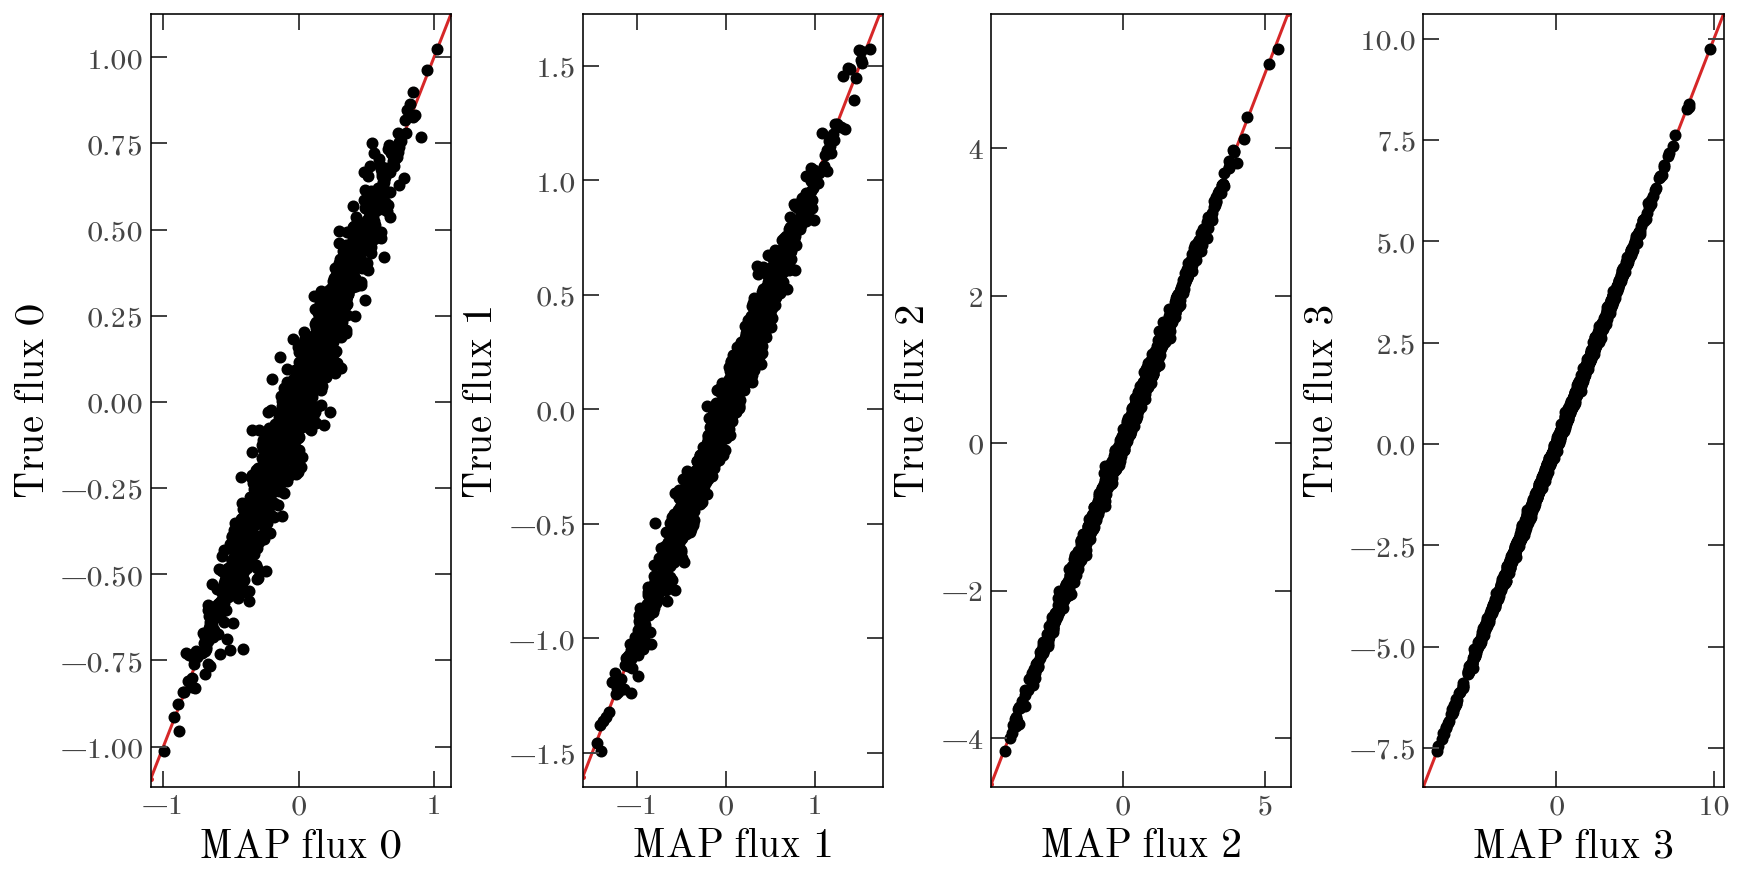

In [62]:
rng = np.random.default_rng(seed=333444)
idx = np.sort(rng.choice(F, size=4, replace=False))
fig, axes = plt.subplots(1, len(idx), figsize=(12, 6))
for i, j in enumerate(idx):
    axes[i].scatter(MAP_train_values["flux"][:, j], data["flux"][:, j])
    axes[i].set_xlabel(f"MAP flux {i}")
    axes[i].set_ylabel(f"True flux {i}")
    axes[i].axline([0, 0], slope=1, color="tab:red", zorder=-100)

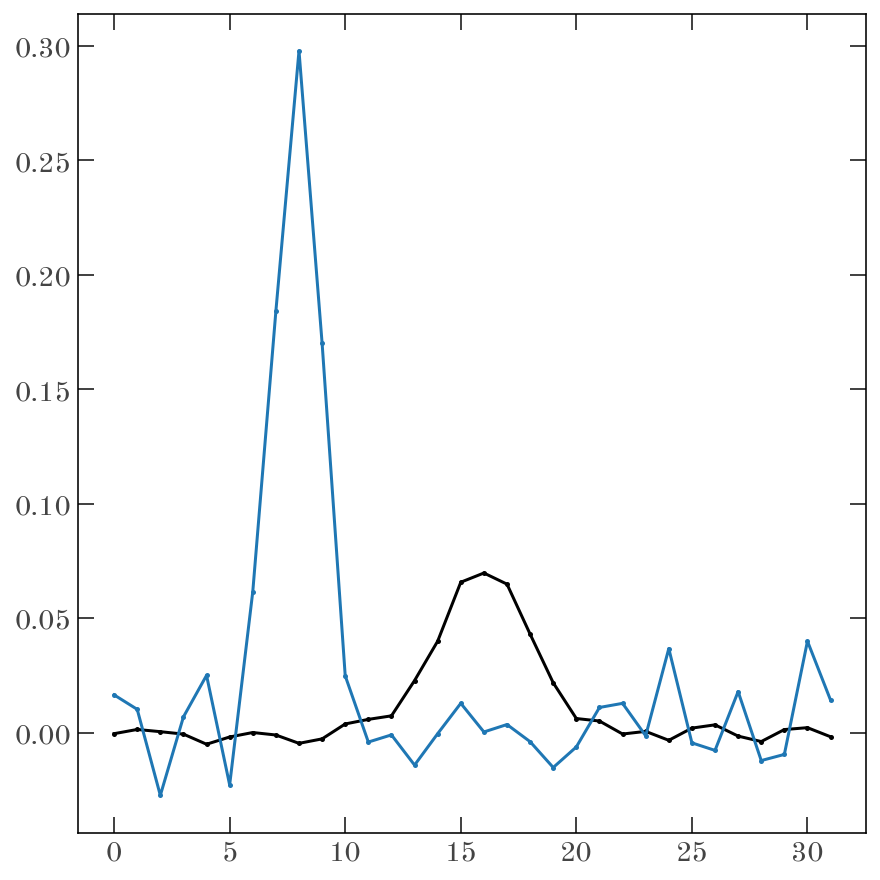

In [66]:
A = MAP_params["labels"]["A"].T
B = MAP_params["flux"]["A"].T

deriv1 = np.linalg.pinv(np.linalg.pinv(B) @ A)
deriv2 = np.linalg.pinv(np.linalg.pinv(A) @ B)

# plt.plot(deriv1.T)
plt.plot(deriv2)

## Optimize for latents for test set

labels -> latents -> flux

and

flux -> latents -> labels

In [78]:
rng_key = jax.random.PRNGKey(112358)

svi_key, sample_key = jax.random.split(rng_key, 2)

_data = {"labels": test_data["label"], "flux": test_data["flux"]}
_err = {
    # "labels": np.full_like(test_data["label_err"], 1e5),
    # "flux": np.full_like(test_data["flux_err"], 1e5),
    "labels": test_data["label_err"],
    "flux": test_data["flux_err"],
}
fixed_params = unpacked_MAP_params.copy()
fixed_params.pop("latent_z")

fixed_model = lambda data, err: paton_model.default_numpyro_model(
    data, err, fixed_params=fixed_params
)

optimizer = numpyro.optim.Adam(1e-3)
svi = SVI(
    model=fixed_model,
    guide=AutoDelta(fixed_model),
    optim=optimizer,
    loss=Trace_ELBO(),
)
svi_results = svi.run(svi_key, 10_000, _data, _err)
# test_unpacked_MAP_params = guide.sample_posterior(sample_key, svi_results.params)
# test_MAP_params = paton_model.unpack_numpyro_params(test_unpacked_MAP_params)
test_latent_z = svi_results.params["latent_z_auto_loc"]

100%|██████████| 10000/10000 [00:02<00:00, 4980.50it/s, init loss: 5200460.7350, avg. loss [9501-10000]: 822024.8823]


In [79]:
test_predict = paton_model.predict_outputs(test_latent_z, MAP_params)

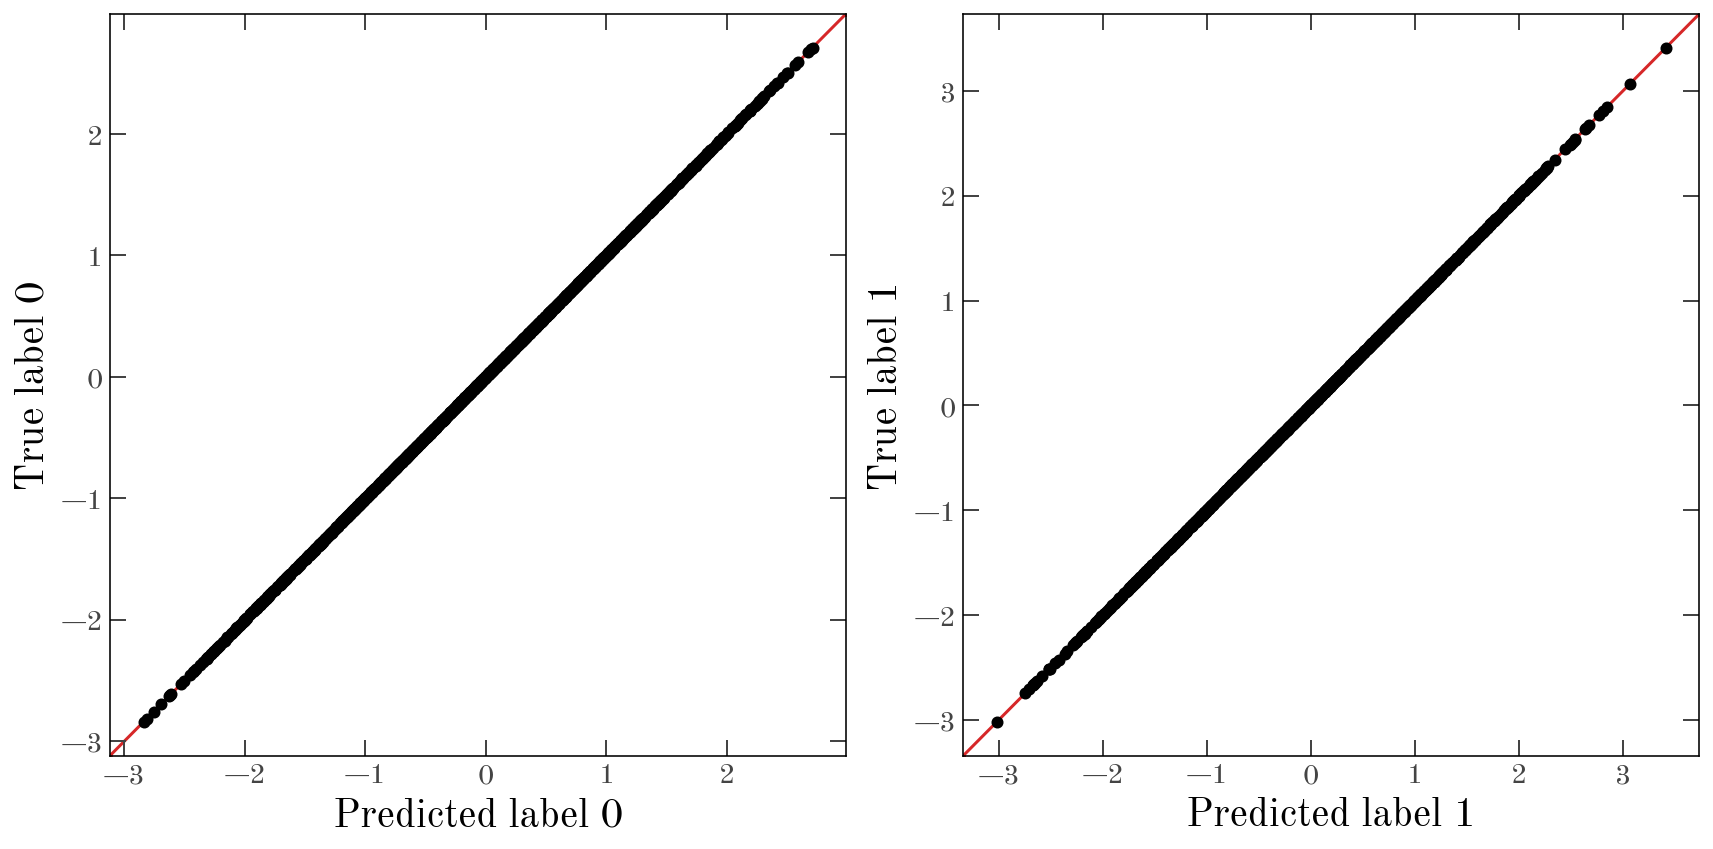

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), layout="tight")
for i, ax in enumerate(axes):
    ax.scatter(test_predict["labels"][:, i], test_data["label"][:, i])
    ax.set_xlabel(f"Predicted label {i}")
    ax.set_ylabel(f"True label {i}")
    ax.axline([0, 0], slope=1, color="tab:red", zorder=-100)

In [81]:
np.std(test_predict["labels"] - test_data_true["label"], axis=0)

Array([0.06080434, 0.06093043], dtype=float64)